In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score, permutation_test_score
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from lightgbm import LGBMClassifier
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import SMOTE, SMOTENC, RandomOverSampler
from imblearn.combine import SMOTETomek
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.utils import resample
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [ ]:
df = pd.read_csv('/content/drive/My Drive/PGPDSE/Capstone/CSV Files/Diabetes_Preprocessed_Before_Feature_Selection.csv')
df.head()

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,diabetesMed,readmitted,preceding_year_visits,number_changes,insulin_treatment
0,Caucasian,0,5,Not Available,Referral,1,41,0,1,Diabetes,Not Required,Not Required,1,None,None,-2,-2,-2,-2,-2,-2,-2,-2,0,0,0,0,no_med
1,Caucasian,0,15,Discharged to home,Emergency,3,59,0,18,"Endocrine, Nutritional, Metabolic, Immunity",Diabetes,"Endocrine, Nutritional, Metabolic, Immunity",9,None,None,-2,-2,-2,-2,-2,-2,-2,1,1,0,0,1,insulin_only
2,AfricanAmerican,0,25,Discharged to home,Emergency,2,11,5,13,"Pregnancy, Childbirth",Diabetes,External causes of injury,6,None,None,-2,-2,-2,0,-2,-2,-2,-2,1,0,3,0,other_meds
3,Caucasian,1,35,Discharged to home,Emergency,2,44,1,16,Infectious and Parasitic,Diabetes,Circulatory,7,None,None,-2,-2,-2,-2,-2,-2,-2,1,1,0,0,1,insulin_only
4,Caucasian,1,45,Discharged to home,Emergency,1,51,0,8,Neoplasms,Neoplasms,Diabetes,5,None,None,-2,-2,-2,0,-2,-2,-2,0,1,0,0,0,insulin_combo


Iteration 0 1601719863.2786472
0.6141231593038822
Iteration 1 1601719870.9209428
0.6080267558528428
Iteration 2 1601719873.6266053
0.6074517631403858
Iteration 3 1601719876.258448
0.6325100133511349
Iteration 4 1601719878.9172356
0.6253342245989305
Iteration 5 1601719881.6549594
0.6093178036605658
Iteration 6 1601719884.344955
0.6049218490189557
Iteration 7 1601719887.0356991
0.616406509465294
Iteration 8 1601719889.7146091
0.6091455273698264
Iteration 9 1601719892.4621835
0.6252498334443705
Iteration 10 1601719895.192363
0.6062416998671979
Iteration 11 1601719897.8669424
0.6152311273694713
Iteration 12 1601719900.6451783
0.6205980066445183
Iteration 13 1601719903.4335244
0.6205744822979292
Iteration 14 1601719906.084635
0.6209650582362729
Iteration 15 1601719908.7645319
0.6172057352450817
Iteration 16 1601719911.4208324
0.6169648774022531
Iteration 17 1601719914.1686776
0.609
Iteration 18 1601719916.8431559
0.6168939142001996
Iteration 19 1601719919.5522568
0.5964854111405835
Iteratio

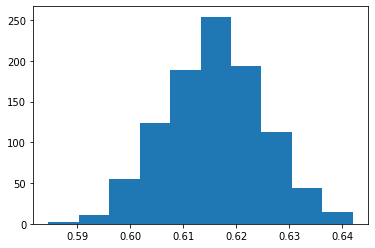

95.0 confidence interval 59.7% and 63.4%


In [ ]:
n_iterations = 1000
# run bootstrap
stats = list()
for i in range(n_iterations):
    print("Iteration", i, time.time())
    # prepare train and test sets
    df_sample = df.sample(frac = 0.9, random_state = i)
    X_sample = df_sample.drop(['readmitted'], 1)
    y_sample = df_sample['readmitted']
    X_dum_sample = pd.get_dummies(X_sample, drop_first = True)
    X_dum_sample.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_dum_sample.columns]
    X_train, X_test, y_train, y_test = train_test_split(X_dum_sample, y_sample, test_size = 0.3, random_state = i, stratify = y_sample)
    # fit model
    model = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1, is_unbalance = True, silent = False,
                       colsample_bytree= 0.7, learning_rate= 0.055499999999999994, max_depth= 309, min_child_samples= 28,
                       n_estimators= 180, num_leaves= 31, reg_alpha= 50, reg_lambda= 5, subsample= 0.7, subsample_freq= 2)
    model.fit(X_train, y_train)
    # evaluate model
    predictions = model.predict(X_test)
    score = recall_score(y_test, predictions)
    print(score)
    stats.append(score)
# plot scores
plt.hist(stats)
plt.show()
# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(stats, p))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))